<a href="https://colab.research.google.com/github/danielegenta/Progetto-MLDL/blob/master/main_lwf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
  Following the iCaRL paper specifications,
  LwF is implemented simirality to iCaRL itself.
  The differences are:
  - No exemplars management
  - For classification, it is used the network output values themselves
  (ref. iCaRL paper section 4.1)
"""

'\n  Following the iCaRL paper specifications,\n  LwF is implemented simirality to iCaRL itself.\n  The differences are:\n  - No exemplars management\n  - For classification, it is used the network output values themselves\n  (ref. iCaRL paper section 4.1)\n'

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DATA_DIR = 'DATA' # here the dataset will be downloaded

# Clone github repository with dataset handler
!rm -r Cifar100/
!rm -r $DATA_DIR
!mkdir "DATA"
if not os.path.isdir('./Cifar100'):
  !git clone https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 2278 (delta 85), reused 107 (delta 38), pack-reused 2119
Receiving objects: 100% (2278/2278), 27.53 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (1351/1351), done.


In [4]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton

if not os.path.isdir('./{}/cifar-100-python'.format(DATA_DIR)):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2020-06-24 20:53:52--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  31.8MB/s    in 5.6s    

2020-06-24 20:53:58 (28.8 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists


In [5]:
from Cifar100 import utils

dictHyperparams = utils.getHyperparams()
print(dictHyperparams)

DEVICE = dictHyperparams["DEVICE"] # 'cuda' or 'cpu'
NUM_CLASSES = dictHyperparams["NUM_CLASSES"] 

BATCH_SIZE = dictHyperparams["BATCH_SIZE"]     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = dictHyperparams["LR"]          # The initial Learning Rate
MOMENTUM = dictHyperparams["MOMENTUM"]       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = dictHyperparams["WEIGHT_DECAY"] # Regularization, you can keep this at the default

NUM_EPOCHS = dictHyperparams["NUM_EPOCHS"]     # Total number of training epochs (iterations over dataset)
GAMMA = dictHyperparams["GAMMA"]         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = dictHyperparams["LOG_FREQUENCY"]
MILESTONES = dictHyperparams["MILESTONES"]
RANDOM_SEED = 16

{'LR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 1e-05, 'NUM_EPOCHS': 70, 'MILESTONES': [49, 63], 'BATCH_SIZE': 128, 'DEVICE': 'cuda', 'GAMMA': 0.2, 'SEED': 66, 'LOG_FREQUENCY': 10, 'NUM_CLASSES': 100}


In [6]:
train_transform, eval_transform = utils.getTransformations()

In [7]:
from Cifar100.Dataset.cifar100 import CIFAR100

# Import dataset
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# check if datasets have been correctly loaded
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [8]:
from Cifar100.reverse_index import ReverseIndex

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [9]:
# performing the train/val split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# performing the test split (coherent with train/val)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [10]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

**LWF implementation**

In [11]:
# default params
from Cifar100.lwf_model import LWF

feature_size = 2048
n_classes = 0
lwf = LWF(feature_size, n_classes, BATCH_SIZE, WEIGHT_DECAY, LR, GAMMA, NUM_EPOCHS, DEVICE,MILESTONES,MOMENTUM, outputs_labels_mapping)
lwf.cuda()

LWF(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, 

In [12]:
def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)

In [13]:
def incrementalTraining(net, train_subsets, val_subsets, test_subsets,eval_transform, reverse_index):
    #groups_accuracies=[] not used right now, use it if you want test on single groups
    all_accuracies = []
    group_id=1
    test_set = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      all_preds_cm = []
      all_labels_cm = []
      print("GROUP: ",group_id)
      if test_set is None:
        test_set = test_subset
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])

      train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
      val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
      test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
      
      #net.train()

      new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)

      # update representation
      net.update_representation(train_subset, new_classes_examined)

      # evaluation on the train set
      net.eval()
      total = 0.0
      correct = 0.0

      for indices, images, labels in train_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = reverse_index.getNodes(labels)
        preds = net.classify(images)
        correct += torch.sum(preds == labels.data).data.item()

      # train Accuracy
      print ('Train Accuracy (on current group): %.2f\n' % (100.0 * correct / len(train_subset)))
      
      # validation on current group
      #net.eval()
      total = 0.0
      correct = 0.0

      for indices, images, labels in val_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = reverse_index.getNodes(labels)
        preds = net.classify(images)
        correct += torch.sum(preds == labels.data).data.item()

      # val Accuracy
      print ('Val Accuracy (on current group): %.2f\n' % (100.0 * correct / len(val_subset)))

      # evaluation on all the previous groups
      #net.eval()
      total = 0.0
      correct = 0.0

      for indices, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        #labels_enc = utils._one_hot_encode(labels, net.n_classes, reverse_index)
        labels = reverse_index.getNodes(labels)
        preds = net.classify(images)
        correct += torch.sum(preds == labels.data).data.item()
      
        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

      accuracy = correct / len(test_set)
      all_accuracies.append(accuracy)
      # Train Accuracy
      print ('Test Accuracy (all groups seen so far): %.2f\n' % (100.0 * accuracy))

      net.n_known = net.n_classes
      print ("the model knows %d classes:\n " % net.n_known)

      group_id+=1
    
    return all_accuracies, np.array(all_preds_cm), np.array(all_labels_cm)

      

In [14]:
accuracies, all_preds_cm, all_labels_cm = incrementalTraining(lwf, train_subsets, val_subsets, test_subsets,eval_transform, outputs_labels_mapping)

GROUP:  1
NUM_EPOCHS:  0 / 70
LOSS:  0.30962786078453064 class loss 0.30962786078453064 dist loss None
NUM_EPOCHS:  1 / 70
LOSS:  0.29536280035972595 class loss 0.29536280035972595 dist loss None
NUM_EPOCHS:  2 / 70
LOSS:  0.28026849031448364 class loss 0.28026849031448364 dist loss None
NUM_EPOCHS:  3 / 70
LOSS:  0.26693961024284363 class loss 0.26693961024284363 dist loss None
NUM_EPOCHS:  4 / 70
LOSS:  0.253984659910202 class loss 0.253984659910202 dist loss None
NUM_EPOCHS:  5 / 70
LOSS:  0.2380066215991974 class loss 0.2380066215991974 dist loss None
NUM_EPOCHS:  6 / 70
LOSS:  0.23957382142543793 class loss 0.23957382142543793 dist loss None
NUM_EPOCHS:  7 / 70
LOSS:  0.266743004322052 class loss 0.266743004322052 dist loss None
NUM_EPOCHS:  8 / 70
LOSS:  0.23804794251918793 class loss 0.23804794251918793 dist loss None
NUM_EPOCHS:  9 / 70
LOSS:  0.23131819069385529 class loss 0.23131819069385529 dist loss None
NUM_EPOCHS:  10 / 70
LOSS:  0.2267456352710724 class loss 0.2267456352

metrics LWF for seed 16


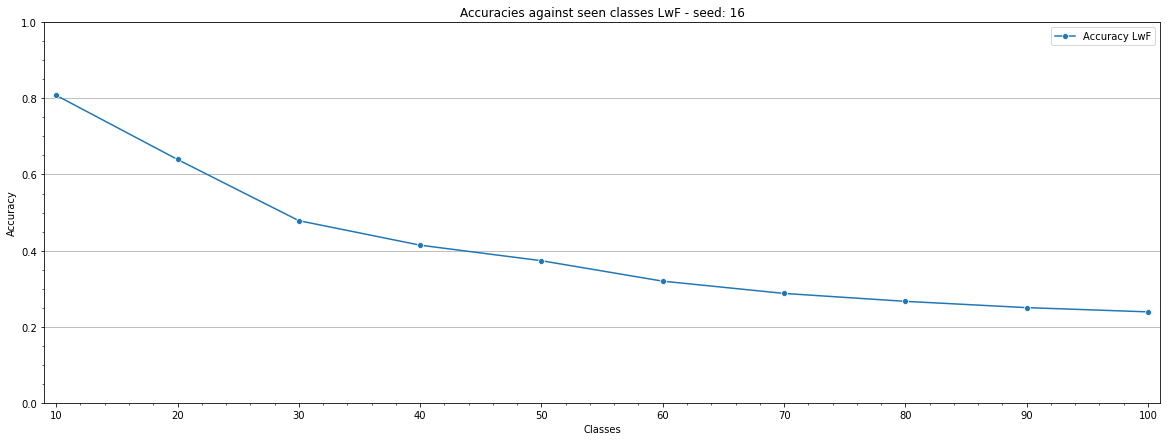

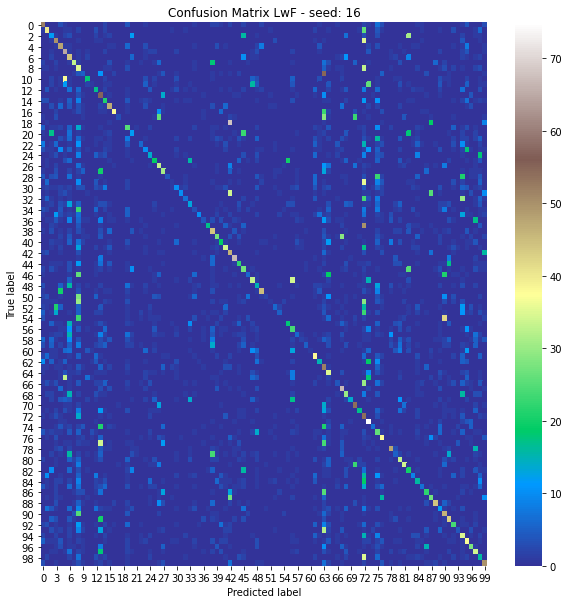

In [15]:
# metrics
method = 'LwF'

print("metrics LWF for seed {}".format(RANDOM_SEED))

# accuracy 
data_plot_line=[]

classes_per_group = 10
for group_classes in range(0,10):
    data_plot_line.append(((group_classes + 1)*classes_per_group, accuracies[group_classes]))

# plot accuracy trend
utils.plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write to JSON file
utils.writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)